# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

def simulate_BM(n_sample, dt, n_timestep):
    noise = torch.randn(size=(n_sample, n_timestep))
    paths_incr = noise * torch.sqrt(torch.tensor(dt))
    paths = torch.cumsum(paths_incr, axis=1)
    BM_paths = torch.cat([torch.zeros((n_sample, 1)), paths], axis=1)
    BM_paths = BM_paths[..., None]
    return BM_paths


def simulate_BS(n_sample, dt, n_timestep, mu, sigma):
    time_grid = torch.linspace(0, dt * n_timestep, n_timestep + 1)
    time_paths = time_grid.expand([n_sample, n_timestep + 1])[..., None]
    BM_paths = simulate_BM(n_sample, dt, n_timestep)
    BS_paths = torch.exp(sigma * BM_paths + (mu - 0.5 * sigma**2) * time_paths)
    return BS_paths


start_date = '2000-01-01'
end_date = '2023-01-01'
t_date = pd.date_range(start=start_date, end=end_date)
n_timestep = len(t_date )
dt = 1/12
mu = 0.1
sigma = 0.2

def get_bs_df():
    
    df = pd.DataFrame({'Date': t_date , 'spx': t_date })
    df.set_index('Date', inplace=True)

    BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
    path = BS_paths[0,:,0].numpy().astype(np.float64)
    df['spx'] = path
    
    return df

df = get_bs_df()
df.to_csv('data/bs.csv')

df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8402 entries, 2000-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     8402 non-null   float64
dtypes: float64(1)
memory usage: 131.3 KB


In [4]:
# samples
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = False # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42


# BS
batch_size = 64 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 60


# real data parameters
# stride = 50 # for real data
# start_date = '1995-01-01' # start date for real data
# end_date = '2918-09-18' # end date for real data


In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 5 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 11

In [6]:
noise_dim = 1 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 5

### Training Related

In [7]:
epochs = 300 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.2 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [8]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [9]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11919.846508125882
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 7
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11919.8
Distribution:                  Normal   AIC:                           23851.7
Method:            Maximum Likelihood   BIC:                           23893.9
                                        No. Observations:                 8401
Date:                Wed, Sep 04 2024   Df Residuals:                     8401
Time:                        16:00:31   Df Model:                            0
                               Volatility Model                              
   

GenLSTM(
  (rnn): LSTM(3, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
len(dataloader.dataset)

139

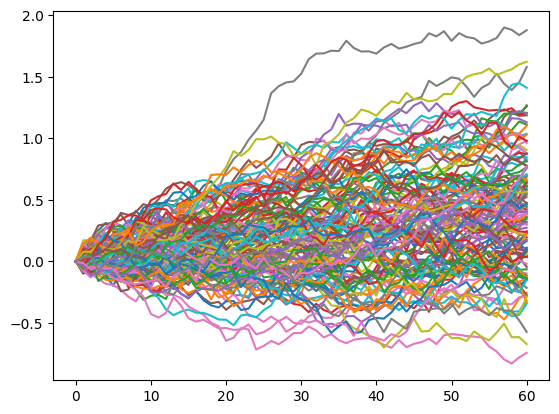

2
torch.Size([64, 61, 2])
torch.Size([64, 60, 1])


In [11]:
# Visualize data
for item in dataloader:
    plt.plot(item[0][:,:,1].T)
plt.show()
print(len(item))
print(item[0].shape)
print(item[1].shape)

# Train MMD-GAN

In [12]:
# train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

In [13]:
from copy import deepcopy
generator0 = deepcopy(generator)

dict = torch.load('runs/Sep03_07-58-53_mbp-hous.local_rq_5/generator.pt', map_location=torch.device('cpu'))
generator.load_state_dict(dict)

<All keys matched successfully>

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


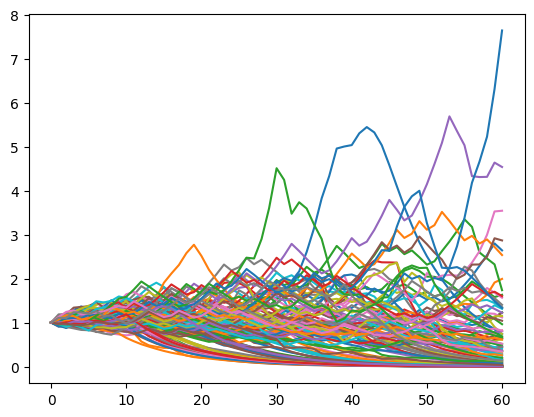

In [14]:
with torch.no_grad():
    for X in tqdm(dataloader):
        if ma: # ma noise is generated for each batch within dataset class
            X, noise = X
            if noise.device != device: noise = noise.to(device)
        else: # Gaussian noise is generated for each batch
            noise = torch.tensor(rng.normal(size=(batch_size, sample_len-1, noise_dim)), device=device, dtype=torch.float32, requires_grad=False)
        X = X.to(device)

        t = X[:,:,:1] # time dimension of path is always first series of the last dim
        if conditional:
            hist_x = X[:,:hist_len,1:] # history portion of path
            output = generator0(noise, t, hist_x=hist_x)
            output = torch.cat([t, output], axis=-1) # concatenate time and history + generated path along time series value dimension
            # remove history portion from X and output to compute MMD only on generated path
            X = X[:,hist_len:,:]
            # output = output[:,hist_len:,:]
        else:
            output = generator(noise, t)
            output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

        plt.plot(output.exp()[:,:,1].cpu().T)


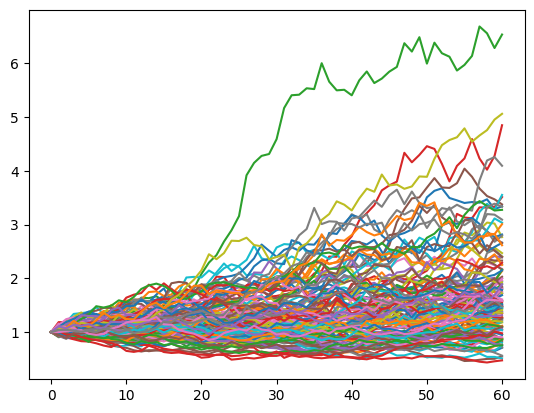

In [15]:
# Visualize data
for item in dataloader:
    # plt.plot(item[0][:,:,0].T)
    # plt.show()
    plt.plot(item[0].exp()[:,:,1].T)
plt.show()

In [16]:
path_generator = MA_path_generator(generator, df, '1995-01-01', '2022-10-19', ma_p, seed=seed)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11814.856259668071
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 7
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -11814.9
Distribution:                  Normal   AIC:                           23641.7
Method:            Maximum Likelihood   BIC:                           23683.9
                                        No. Observations:                 8327
Date:                Wed, Sep 04 2024   Df Residuals:                     8327
Time:                        16:00:33   Df Model:                            0
                               Volatility Model                              
   